In [11]:
import torch
import torchvision
from torch.utils.data import Dataset
import os
from PIL import Image

In [12]:
from os import listdir
from os.path import isfile
from os.path import join
from os.path import isdir
from os.path import abspath

class CustomDataSet(Dataset):
    def __init__(self, main_dir):
        self.main_dir = main_dir
        self.transform = torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),
            # torchvision.transforms.Grayscale(num_output_channels=1)
        ])
        all_imgs = os.listdir(main_dir)
        self.total_imgs = all_imgs
        
        self.labels = [name for name in listdir(main_dir) if isdir(join(main_dir, name))]
        self.imgs = []
        for label in self.labels:
            self.imgs.extend([(label, abspath(join(main_dir, label, f))) for f in listdir(join(main_dir, label)) if isfile(join(main_dir, label, f))])      
            
    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img_label, img_loc = self.imgs[idx]
        image = Image.open(img_loc)# .convert("RGB")
        tensor_image = self.transform(image)
        return img_label, tensor_image

In [13]:
img_data = CustomDataSet('scales/')

label_map = {
            '12cm': 0,
            '5cm': 1,
            '16cm': 2
}

targets = torch.tensor([label_map[label] for label, path in img_data.imgs])
class_counts = torch.bincount(targets)

weights = 1. / class_counts
samples_weights = weights[targets]
sampler = torch.utils.data.sampler.WeightedRandomSampler(samples_weights, len(samples_weights), replacement=True)

train_loader = torch.utils.data.DataLoader(dataset=img_data, batch_size=8, sampler=sampler)
#train_loader = torch.utils.data.DataLoader(img_data, batch_size=12, shuffle=True)

In [19]:
example = next(iter(train_loader))
example[0]

('16cm', '16cm', '5cm', '12cm', '5cm', '16cm', '5cm', '12cm')

In [5]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        #self.conv2 = nn.Conv2d(6, 16, 5)
        #self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(2064, 128)
        self.dropout = torch.nn.Dropout(p=0.4)
        self.fc3 = nn.Linear(128, 3)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        #x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        #x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [6]:
net = Net()
device = 'cuda:1'
net.to(device)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc2): Linear(in_features=2064, out_features=128, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
  (fc3): Linear(in_features=128, out_features=3, bias=True)
)

In [7]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=1e-4, momentum=0.9)

In [8]:
from matplotlib import pyplot as plt

/srv/jupyterhub/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


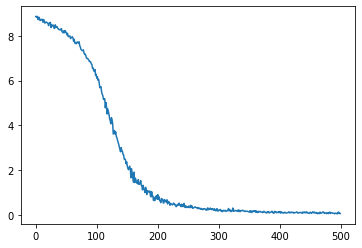

In [9]:
loss_log = []
for epoch in range(500):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        labels, inputs = data
        inputs = inputs.to(device)
        
        label_map = {
            '12cm': 0,
            '5cm': 1,
            '16cm': 2
        }
        # print(inputs.max())
        labels = torch.tensor([label_map[e] for e in labels]).to(device)
        # print(labels)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
    loss_log.append(running_loss)

    #print('loss: %.5f' % (running_loss))
     
plt.plot(loss_log)
#print('Finished Training')

In [10]:
torch.save(net.state_dict(), 'scale_classifier_weights.pt')